# Run 5812

- File 0000
- Taken on June 8th, 8 kV
- High Krypton rate
- DAQ Bug producing doubling of S1 should be fixed

## Imports

In [117]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-06-09 00:53:31


In [118]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [120]:
from invisible_cities.reco.dst_functions  import load_dst

In [121]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

In [122]:
from irotea.kr_plt_functions import plot_S12
from irotea.kr_plt_functions import plot_pmt_signals_vs_time_mus
from irotea.kr_plt_functions import plot_pmt_waveforms
from irotea.kr_plt_functions import plot_sipm_map
from irotea.kr_plt_functions import plot_cwf_vs_time_mus

In [123]:
from invisible_cities.icaro.mpl_functions import set_plot_labels

## NB functions

### Run Number and file number

In [124]:
run_number = 5812
file_number = '0000'

## Data base

In [125]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

### Opening file

In [126]:
filename = f'/Users/jjgomezcadenas/Projects/ICDEV/data/{run_number}/run_{run_number}_{file_number}_waveforms.h5'
print(f'opening filename {filename}')
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

opening filename /Users/jjgomezcadenas/Projects/ICDEV/data/5812/run_5812_0000_waveforms.h5


In [127]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf
evts = h5rwf.root.Run.events[:]
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


## S1 and S2 parameters

In [158]:
s1params = S12Params(time = minmax(min    = 100 * units.mus,
                                   max    = 640 * units.mus),
                           stride = 4,
                           length = minmax(min = 5, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [159]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

### Event 0

In [160]:
event=0

In [161]:
evts[event]

(1, 1528498071147)

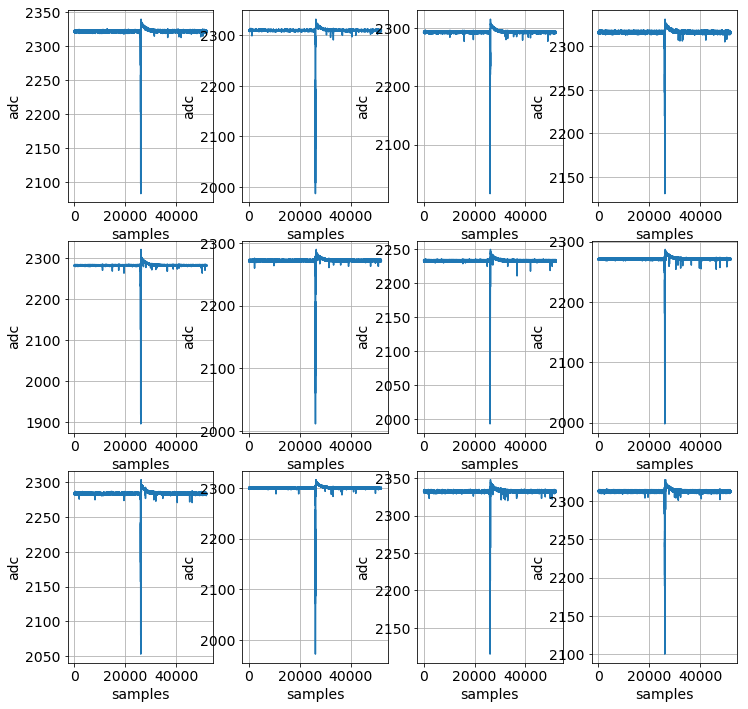

In [162]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

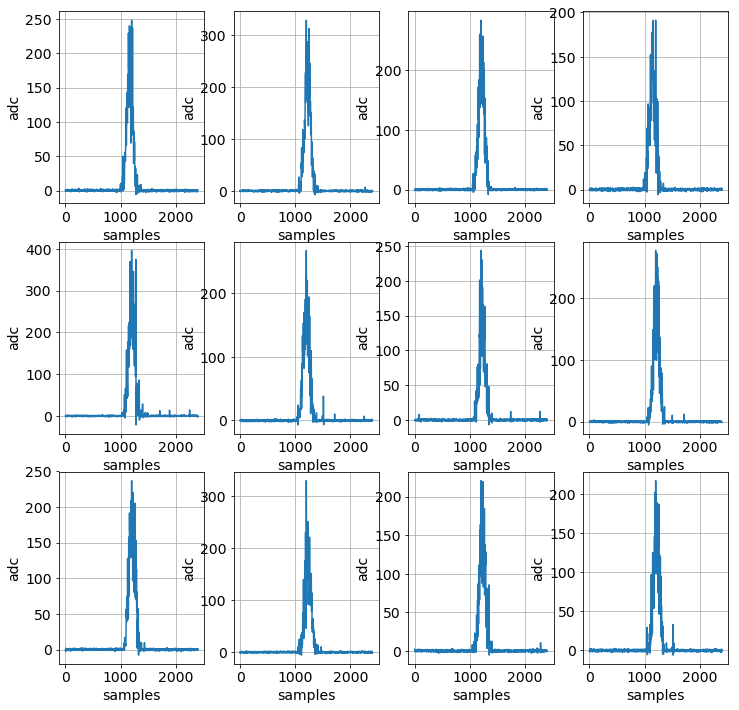

In [163]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [164]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

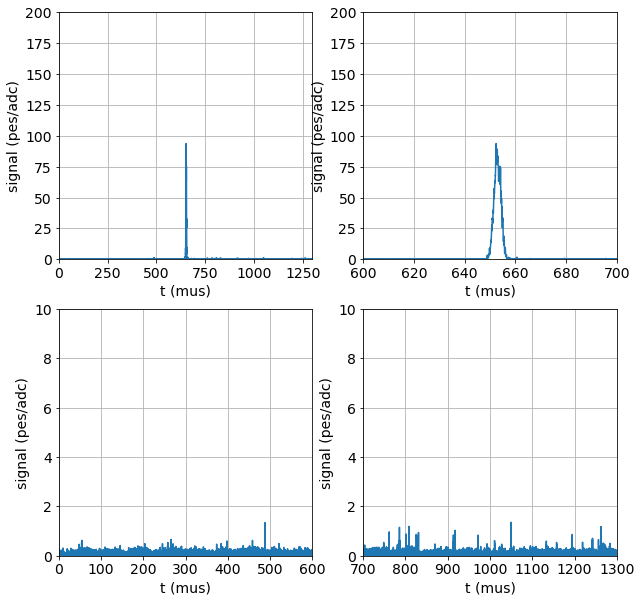

In [165]:
plot_cwf_vs_time_mus(cwf_sum,
                         t_min      =    0,
                         t_max      = 1300,
                         t_trg      = 650,
                         t_trgw     = 50,
                         s2_min =    0, 
                         s2_max =  200,
                         s1_min =    0, 
                         s1_max =  10,
                         figsize=(10,10))

In [166]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.8 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[]

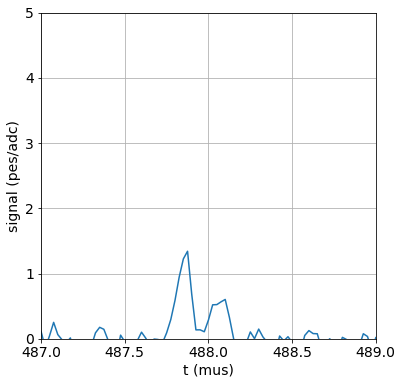

In [167]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =487,
                            t_max      = 489,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [141]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 649.31210636  650.35025042  651.28144884  652.25487555  653.19048269
 654.15321387  655.10581923  656.04864319] µs
       Time @ max energy: 653.1904826918602
       Width: 6.736536827443866 µs
       Height: 3053.3867722740415 pes
       Energy: 11532.314430685752 pes
       Charge: 0.0 pes
       RMS: 1.302903599620819 µs]

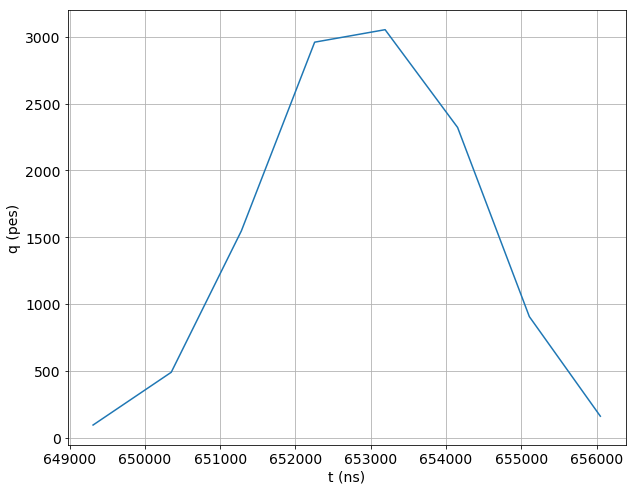

In [142]:
plot_S12(s2s)

In [143]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)

[[   7]
 [  35]
 [ 677]
 [ 678]
 [ 684]
 [ 685]
 [ 686]
 [ 692]
 [ 693]
 [ 694]
 [ 695]
 [ 701]
 [ 853]
 [1372]
 [1466]
 [1509]]


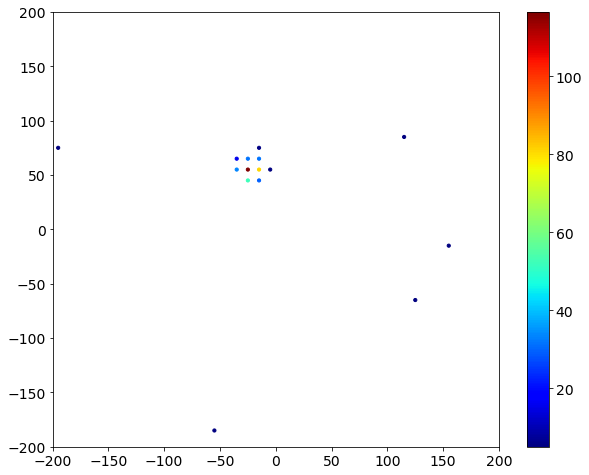

In [144]:
plot_sipm_map(sipm_cal, xs, ys)

## Event 1

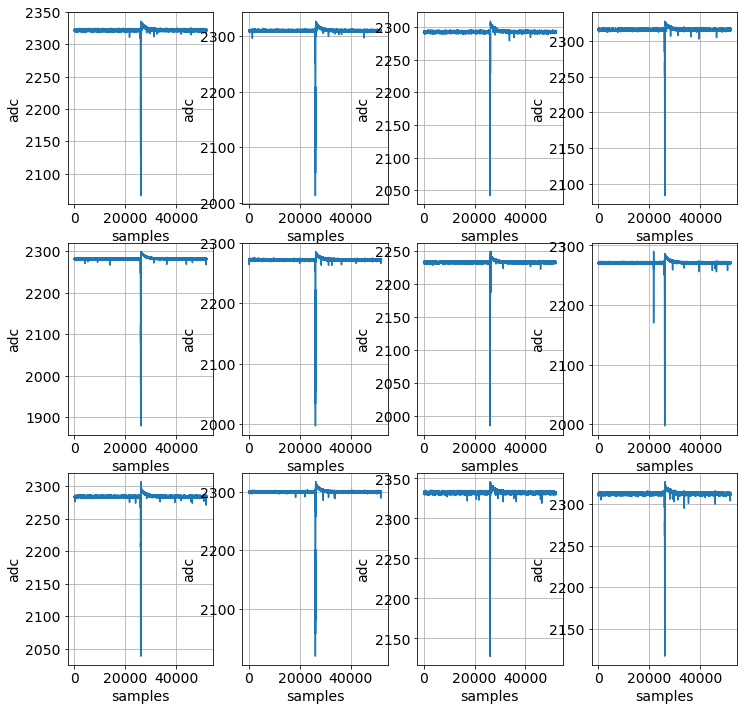

In [168]:
event=1
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

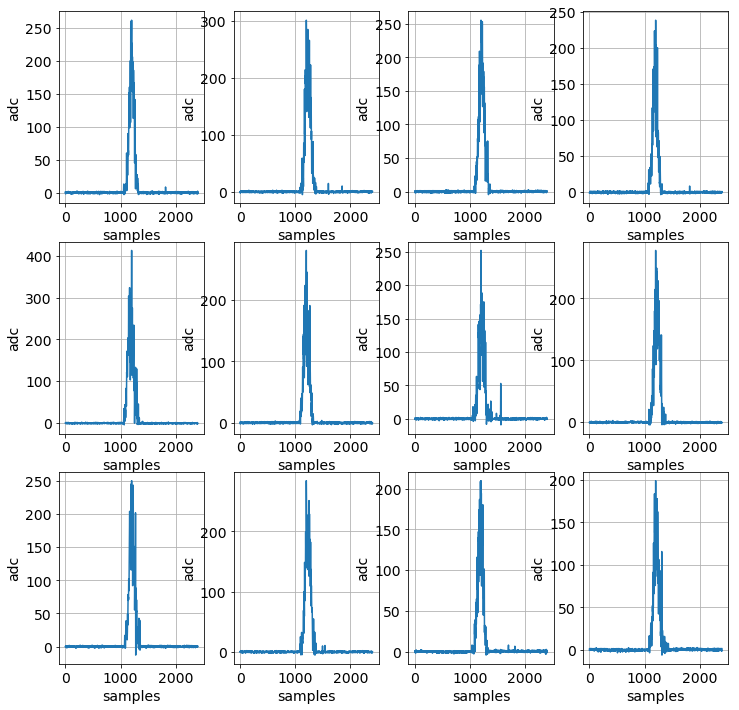

In [169]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [170]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

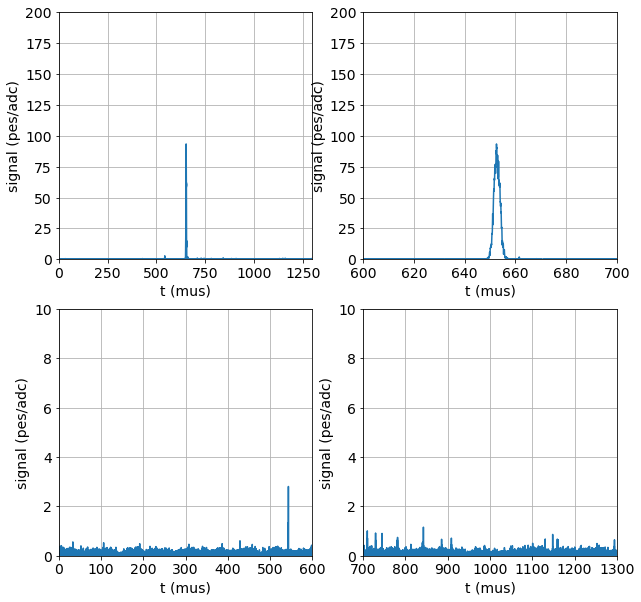

In [171]:
plot_cwf_vs_time_mus(cwf_sum,
                         t_min      =    0,
                         t_max      = 1300,
                         t_trg      = 650,
                         t_trgw     = 50,
                         s2_min =    0, 
                         s2_max =  200,
                         s1_min =    0, 
                         s1_max =  10,
                         figsize=(10,10))

In [172]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 542.3    542.325  542.35   542.375  542.4  ] µs
 Time @ max energy: 542.325
 Width: 0.1 µs
 Height: 1.327634198701431 pes
 Energy: 4.104433215113974 pes
 Charge: 0.0 pes
 RMS: 0.03128046040286562 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 543.05   543.075  543.1    543.125  543.15 ] µs
 Time @ max energy: 543.1
 Width: 0.1 µs
 Height: 2.805188916725868 pes
 Energy: 9.569796088672126 pes
 Charge: 0.0 pes
 RMS: 0.028728943400920005 µs]

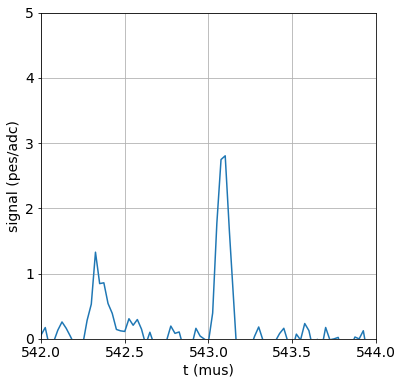

In [173]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =542,
                            t_max      = 544,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [151]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 649.64306182  650.5751223   651.53970551  652.47552347  653.43408232
 654.35105542  655.33415096  656.30275286] µs
       Time @ max energy: 652.4755234688121
       Width: 6.659691031709547 µs
       Height: 3222.7684641847773 pes
       Energy: 10141.428975968902 pes
       Charge: 0.0 pes
       RMS: 1.139643885370242 µs]

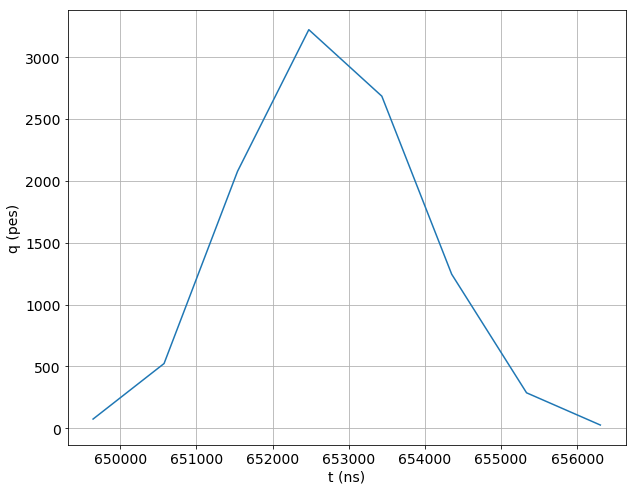

In [152]:
plot_S12(s2s)

[[  7]
 [499]
 [768]
 [769]
 [776]
 [777]
 [784]
 [785]
 [793]
 [839]
 [847]
 [855]
 [863]]


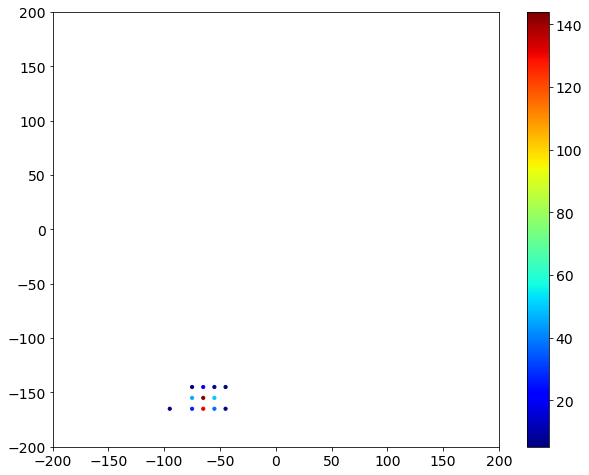

In [153]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 2

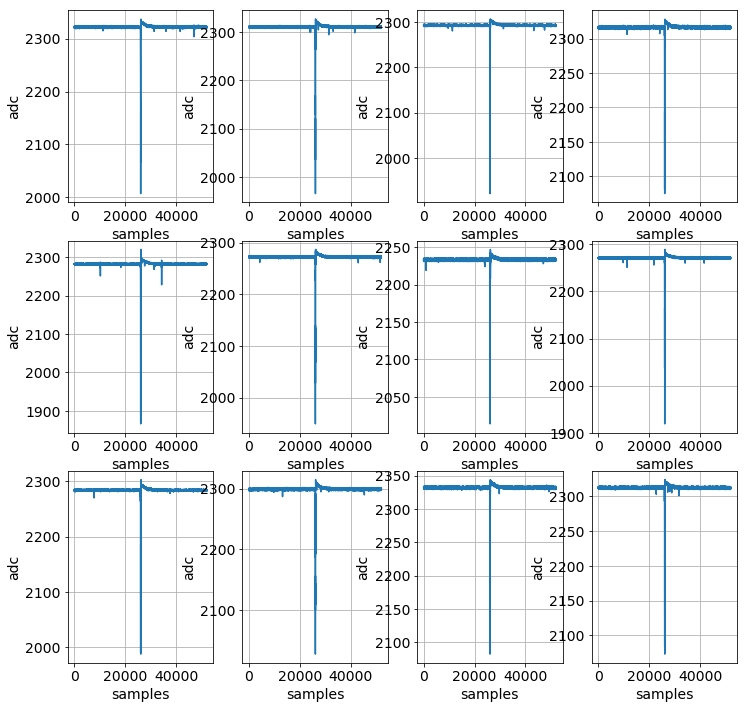

In [174]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

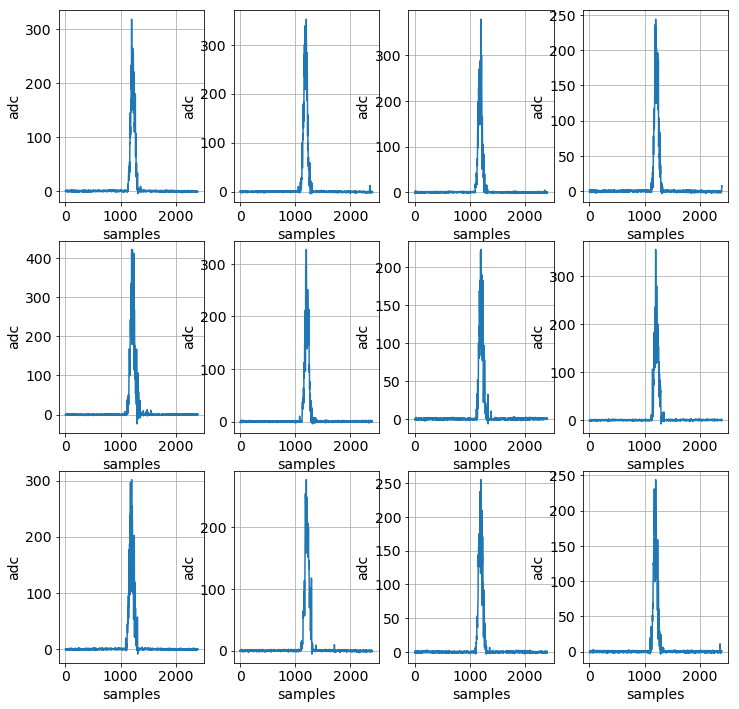

In [175]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [176]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

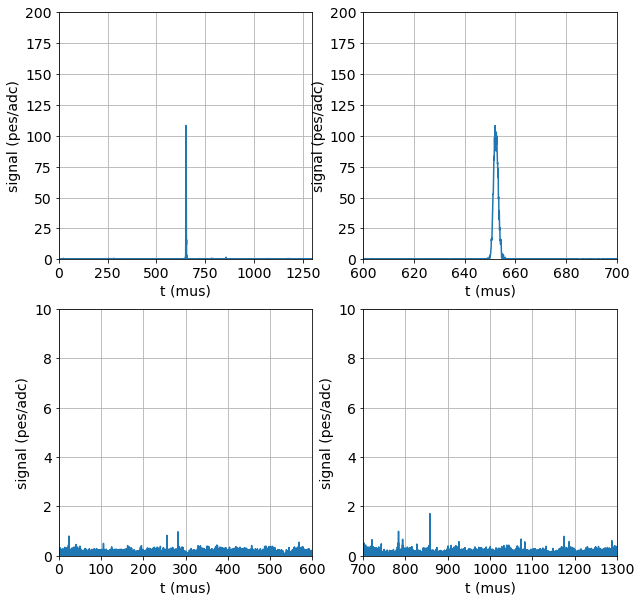

In [177]:
plot_cwf_vs_time_mus(cwf_sum)

In [178]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[]

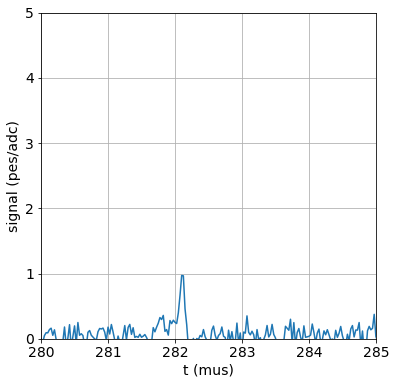

In [183]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =280,
                            t_max      = 285,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [184]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 7
       Times: [ 649.77529799  650.71580962  651.61253292  652.5207033   653.41611736
 654.3474579   655.38454526] µs
       Time @ max energy: 652.5207032996359
       Width: 5.609247266231804 µs
       Height: 3679.851369624093 pes
       Energy: 9287.315166619555 pes
       Charge: 0.0 pes
       RMS: 0.8550850634751956 µs]

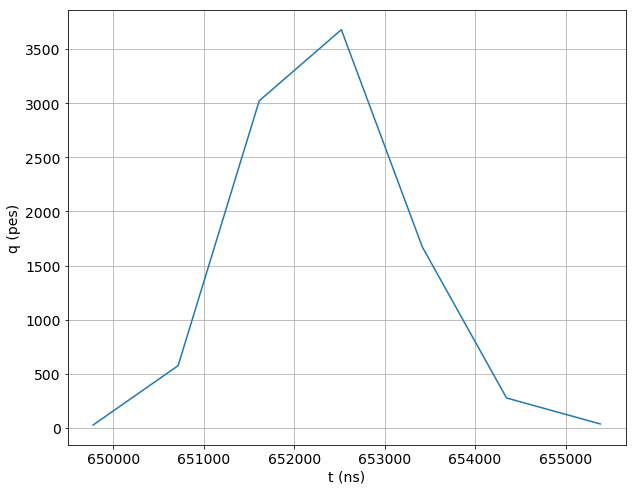

In [187]:
plot_S12(s2s)

[[   7]
 [  43]
 [  45]
 [  51]
 [  52]
 [  53]
 [  58]
 [  59]
 [  60]
 [  61]
 [  62]
 [ 260]
 [ 261]
 [ 262]
 [ 268]
 [ 280]
 [ 510]
 [ 744]
 [1338]]


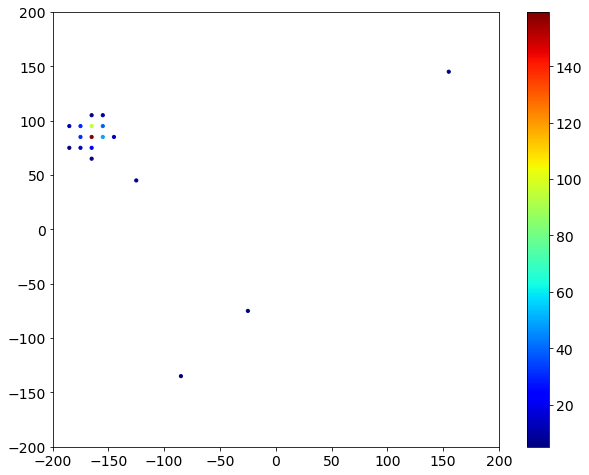

In [188]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 3

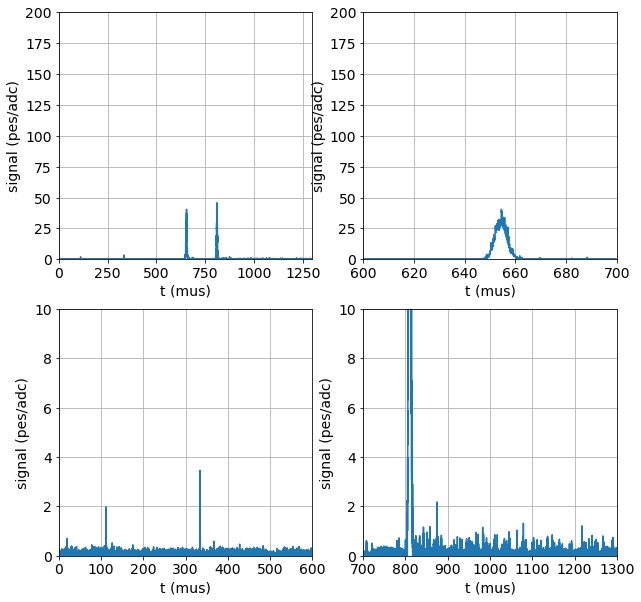

In [189]:
event=3
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [190]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 16
       Times: [ 111.325  111.35   111.375  111.4    111.425  111.45   111.475  111.5
 111.525  111.55   111.575  111.6    111.625  111.65   111.675  111.7  ] µs
       Time @ max energy: 111.375
       Width: 0.375 µs
       Height: 1.9763398650710997 pes
       Energy: 13.646842678993277 pes
       Charge: 0.0 pes
       RMS: 0.11261464599770751 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 333.925  333.95   333.975  334.     334.025  334.05 ] µs
 Time @ max energy: 333.975
 Width: 0.125 µs
 Height: 3.458856428764967 pes
 Energy: 14.558682584570052 pes
 Charge: 0.0 pes
 RMS: 0.035014757362220254 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 334.625  334.65   334.675  334.7    334.725  334.75 ] µs
 Time @ max energy: 334.625
 Width: 0.125 µs
 Height: 0.8754433420595475 pes
 Energy:

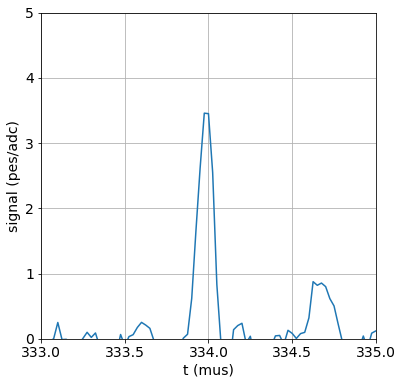

In [191]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =333,
                            t_max      = 335,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [192]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 648.618786    649.61438903  650.60086986  651.59719447  652.57780608
 653.55800124  654.56242093  655.55238329  656.52992226  657.480693
 658.57793309  659.5157068   660.509298    661.63123226  662.33189083] µs
       Time @ max energy: 654.5624209323596
       Width: 13.713104821718996 µs
       Height: 1302.9567300053868 pes
       Energy: 7580.350263654575 pes
       Charge: 0.0 pes
       RMS: 2.3728481565845905 µs]

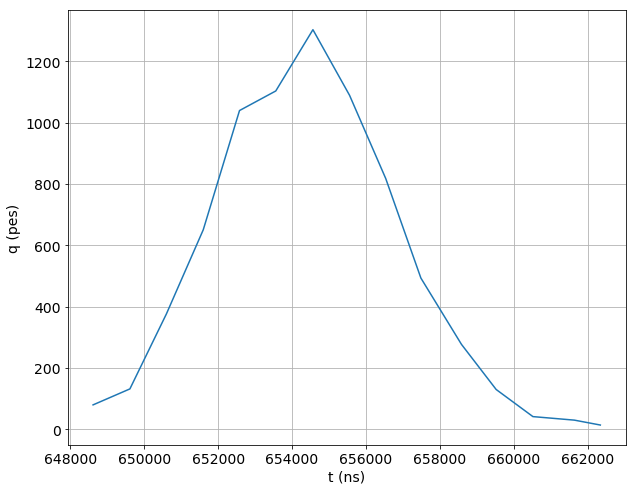

In [193]:
plot_S12(s2s)

[[   7]
 [ 619]
 [ 620]
 [ 626]
 [ 627]
 [ 628]
 [ 634]
 [ 635]
 [ 636]
 [1305]
 [1452]
 [1453]
 [1459]
 [1460]
 [1461]
 [1462]
 [1468]
 [1469]
 [1489]
 [1668]]


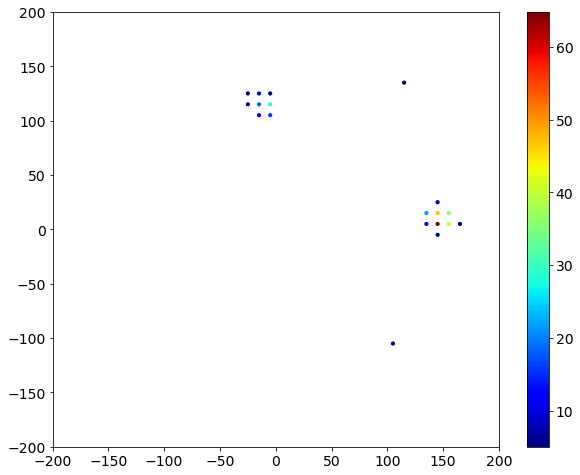

In [194]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 4

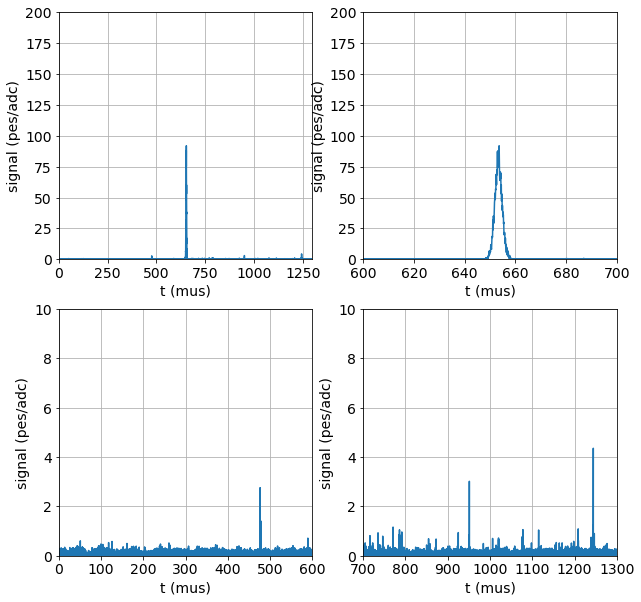

In [195]:
event=4
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [196]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 476.1    476.125  476.15   476.175  476.2    476.225] µs
 Time @ max energy: 476.175
 Width: 0.125 µs
 Height: 2.7573161907238335 pes
 Energy: 11.883266162571157 pes
 Charge: 0.0 pes
 RMS: 0.03590559812933758 µs]

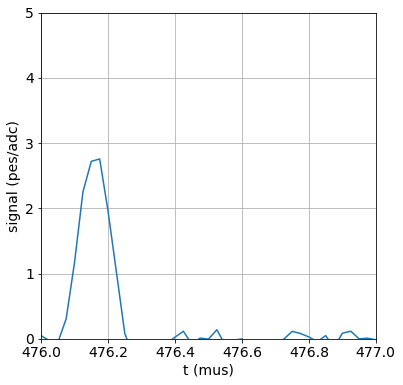

In [197]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =476,
                            t_max      = 477,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [198]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 648.87699703  649.93918748  650.95978767  651.89653648  652.86651486
 653.80907946  654.78708062  655.75720366  656.78223256  657.68871996] µs
       Time @ max energy: 652.8665148614903
       Width: 8.811722921773326 µs
       Height: 2974.383191413708 pes
       Energy: 11419.891468287255 pes
       Charge: 0.0 pes
       RMS: 1.448414256231642 µs]

[[   7]
 [ 574]
 [1120]
 [1181]
 [1182]
 [1183]
 [1189]
 [1190]
 [1191]
 [1198]
 [1271]]


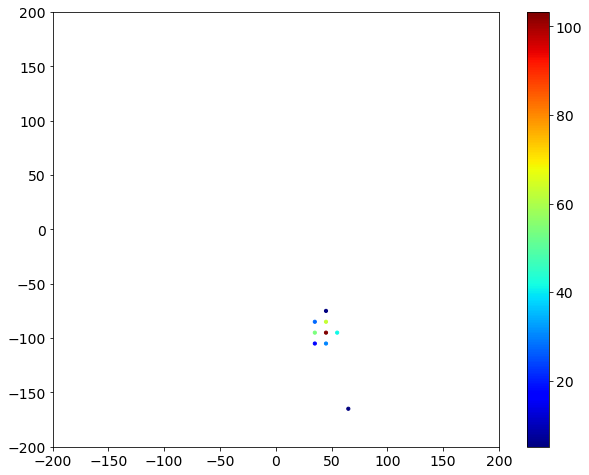

In [199]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 5

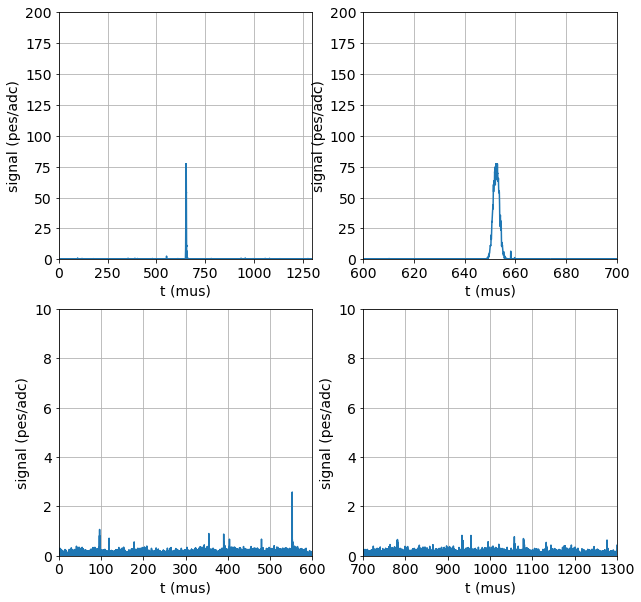

In [200]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [201]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 389.95   389.975  390.     390.025  390.05   390.075  390.1    390.125] µs
 Time @ max energy: 390.025
 Width: 0.175 µs
 Height: 0.8785580992135683 pes
 Energy: 5.650875889864919 pes
 Charge: 0.0 pes
 RMS: 0.05481267257466072 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 552.1    552.125  552.15   552.175  552.2    552.225  552.25   552.275
 552.3    552.325  552.35   552.375] µs
       Time @ max energy: 552.175
       Width: 0.275 µs
       Height: 2.5802884488683917 pes
       Energy: 14.522050679659818 pes
       Charge: 0.0 pes
       RMS: 0.06769647282006148 µs]

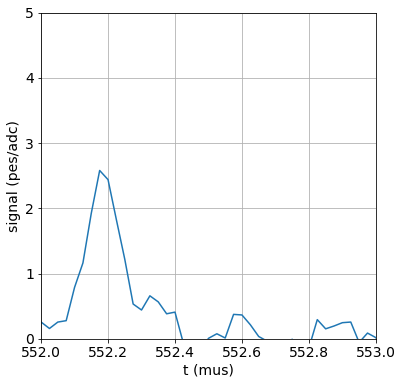

In [202]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =552,
                            t_max      = 553,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [203]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 649.58540696  650.54265713  651.46760869  652.41385946  653.35642233
 654.30092494  655.26044434  655.98348462] µs
       Time @ max energy: 652.4138594644942
       Width: 6.3980776604110146 µs
       Height: 2867.2227678044546 pes
       Energy: 9167.155136811674 pes
       Charge: 0.0 pes
       RMS: 1.12857544782529 µs]

[[  7]
 [ 32]
 [ 40]
 [ 48]
 [102]
 [103]
 [109]
 [110]
 [111]
 [118]
 [119]]


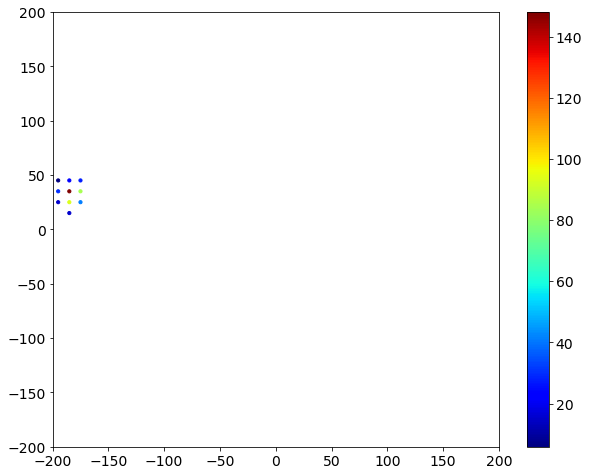

In [204]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 6

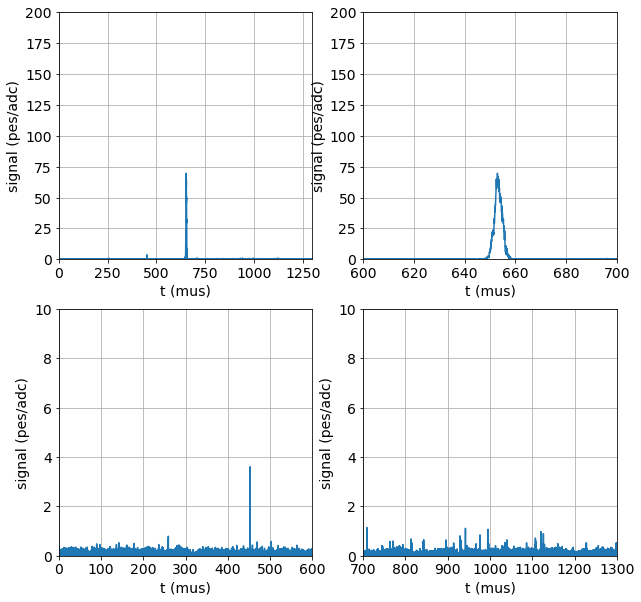

In [205]:
event=6
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [206]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 16
       Times: [ 452.55   452.575  452.6    452.625  452.65   452.675  452.7    452.725
 452.75   452.775  452.8    452.825  452.85   452.875  452.9    452.925] µs
       Time @ max energy: 452.625
       Width: 0.375 µs
       Height: 3.602782357036983 pes
       Energy: 19.670588437652583 pes
       Charge: 0.0 pes
       RMS: 0.09075716486141187 µs]

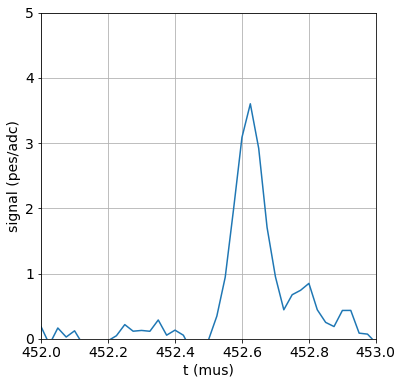

In [207]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =452,
                            t_max      = 453,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [208]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.08314124  650.07933409  650.97972146  652.0162683   652.93891889
 653.91305915  654.89844397  655.80503665  656.82585562  657.72538544] µs
       Time @ max energy: 652.938918887817
       Width: 8.64224420247355 µs
       Height: 2510.0723192577907 pes
       Energy: 9340.698377358667 pes
       Charge: 0.0 pes
       RMS: 1.5015293459161527 µs]

[[   7]
 [ 499]
 [ 500]
 [ 501]
 [ 506]
 [ 507]
 [ 508]
 [ 509]
 [ 758]
 [ 768]
 [ 769]
 [ 776]
 [ 828]
 [ 838]
 [ 839]
 [ 847]
 [1285]
 [1372]
 [1575]]


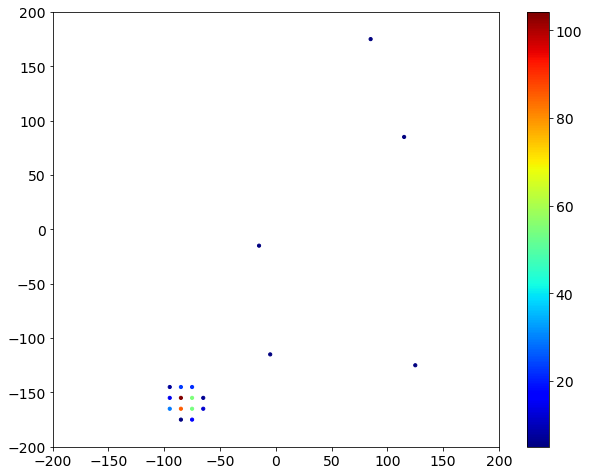

In [209]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 7

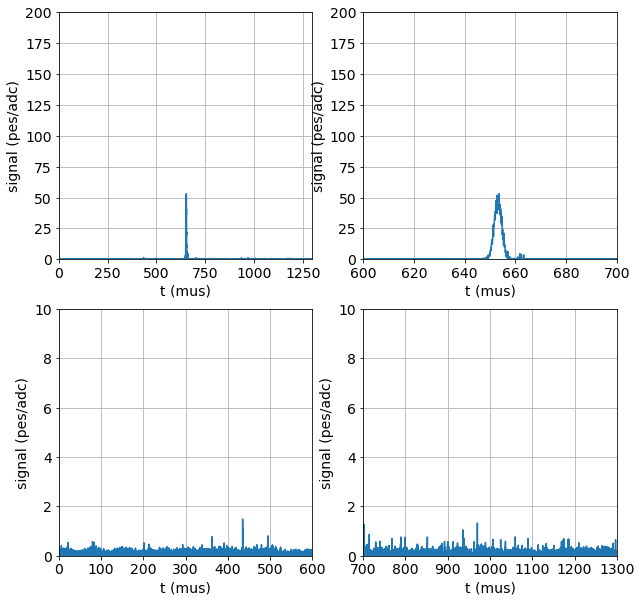

In [210]:
event=7
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [211]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 17
       Times: [ 434.8    434.825  434.85   434.875  434.9    434.925  434.95   434.975
 435.     435.025  435.05   435.075  435.1    435.125  435.15   435.175
 435.2  ] µs
       Time @ max energy: 434.825
       Width: 0.4 µs
       Height: 1.4860091585145008 pes
       Energy: 13.944375651116971 pes
       Charge: 0.0 pes
       RMS: 0.13472574107626703 µs]

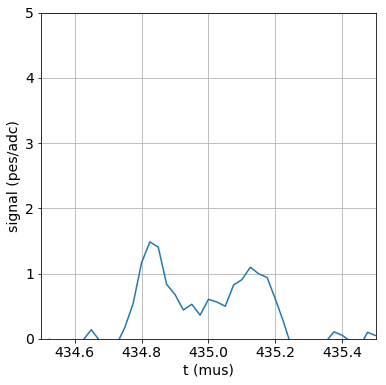

In [213]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =434.5,
                            t_max      = 435.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [216]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.1 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 648.98084032  650.01357786  650.96789925  651.93252052  652.89987988
 653.85250681  654.81037359  655.74811878  656.76182265  657.72848895] µs
       Time @ max energy: 652.8998798796835
       Width: 8.74764862892672 µs
       Height: 1877.465430596732 pes
       Energy: 7239.12597852833 pes
       Charge: 0.0 pes
       RMS: 1.480724972088359 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 3
 Times: [ 661.56674127  662.34763696  663.26579662] µs
 Time @ max energy: 661.5667412704937
 Width: 1.6990553529633907 µs
 Height: 20.85622694472426 pes
 Energy: 44.133213691001345 pes
 Charge: 0.0 pes
 RMS: 0.7121847450637434 µs]

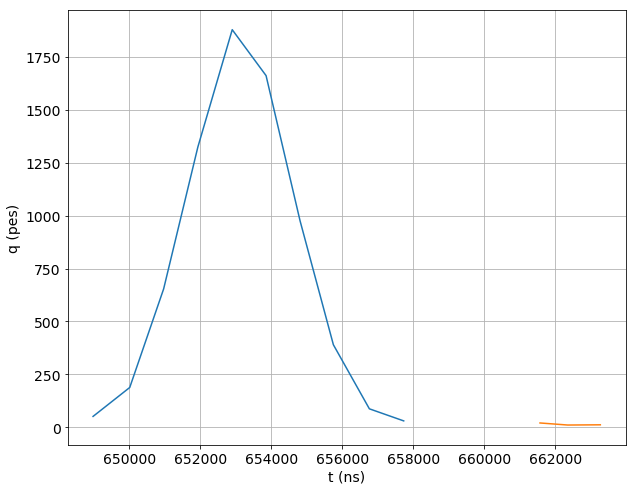

In [215]:
plot_S12(s2s)

[[  7]
 [215]
 [444]
 [544]
 [545]
 [552]
 [553]
 [554]
 [560]
 [561]]


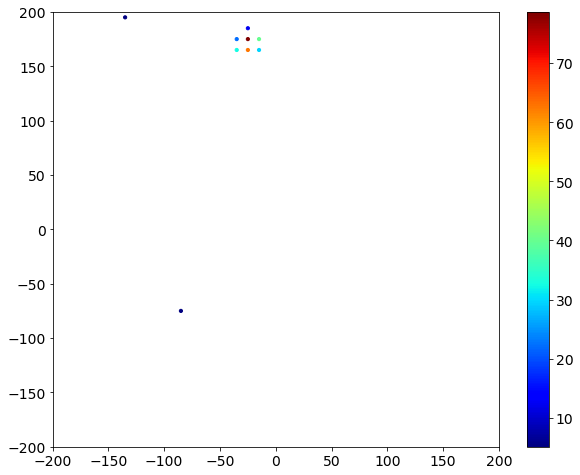

In [217]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 8

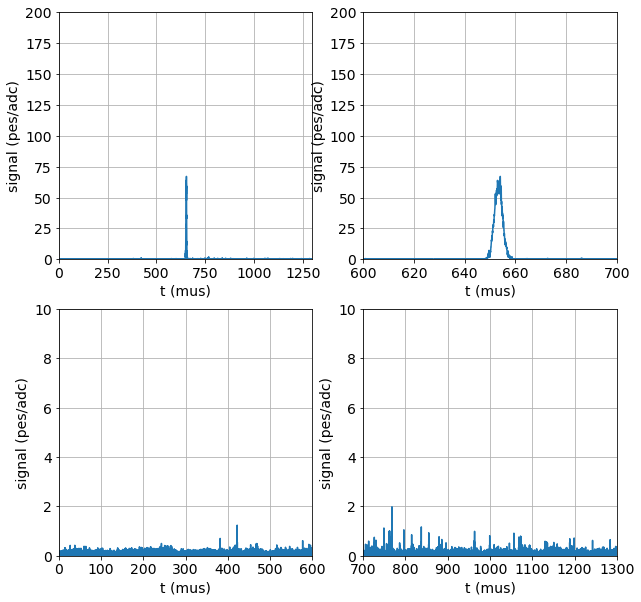

In [218]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [219]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 421.925  421.95   421.975  422.     422.025  422.05   422.075  422.1  ] µs
 Time @ max energy: 421.975
 Width: 0.175 µs
 Height: 1.1831463277321452 pes
 Energy: 7.871051160134787 pes
 Charge: 0.0 pes
 RMS: 0.052887118856129414 µs]

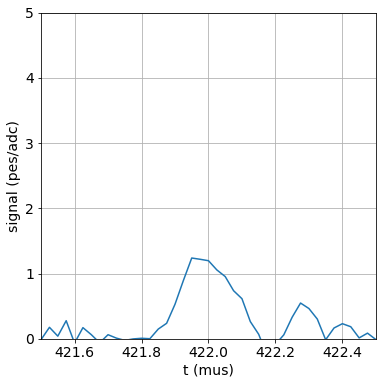

In [221]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =421.5,
                            t_max      = 422.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [222]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 649.31360931  650.30015135  651.2218155   652.195769    653.16150596
 654.1323083   655.10580403  656.09912339  657.07446471  658.03758312
 658.69509418] µs
       Time @ max energy: 653.1615059615241
       Width: 9.381484870166634 µs
       Height: 2331.3650005288227 pes
       Energy: 9755.432466480204 pes
       Charge: 0.0 pes
       RMS: 1.5612312145180687 µs]

[[   7]
 [ 164]
 [ 778]
 [1195]
 [1202]
 [1203]
 [1204]
 [1205]
 [1210]
 [1211]
 [1212]
 [1542]
 [1632]]


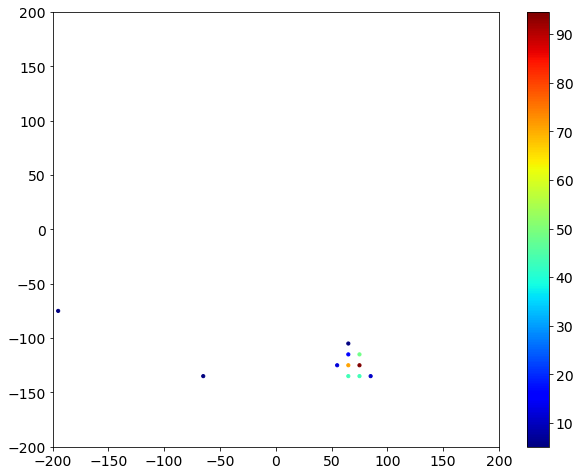

In [223]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

## Event 9

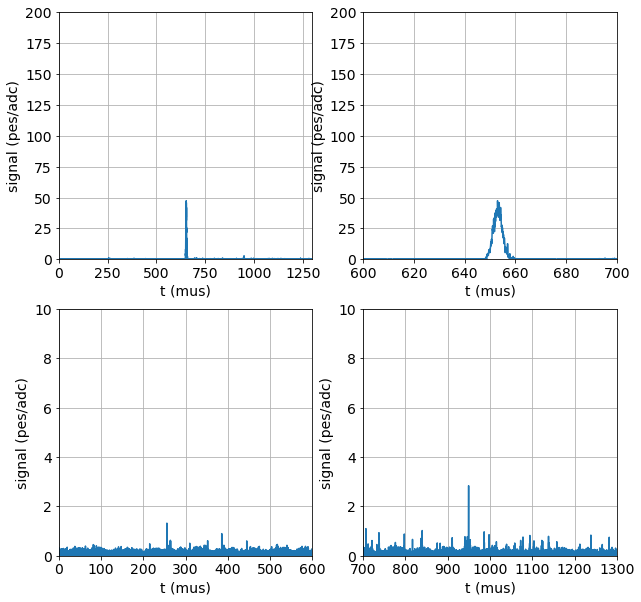

In [224]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_cwf_vs_time_mus(cwf_sum)

In [225]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 255.575  255.6    255.625  255.65   255.675  255.7  ] µs
 Time @ max energy: 255.625
 Width: 0.125 µs
 Height: 1.3675189631417846 pes
 Energy: 6.062930660405715 pes
 Charge: 0.0 pes
 RMS: 0.03807964464027914 µs]

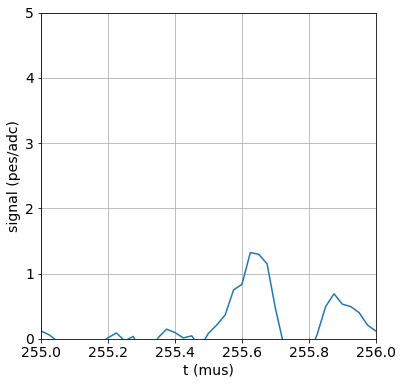

In [226]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =255,
                            t_max      = 256,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [227]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 649.02486886  649.985923    650.97602875  651.93367235  652.91850225
 653.89406043  654.87317069  655.84592486  656.82623429  657.84186292
 658.93008073] µs
       Time @ max energy: 652.9185022549801
       Width: 9.905211868470534 µs
       Height: 1567.3502325948891 pes
       Energy: 7259.307849107322 pes
       Charge: 0.0 pes
       RMS: 1.7590899309165788 µs]

[[   7]
 [  53]
 [  54]
 [  61]
 [  62]
 [  63]
 [ 261]
 [ 262]
 [ 269]
 [ 270]
 [1000]
 [1680]]


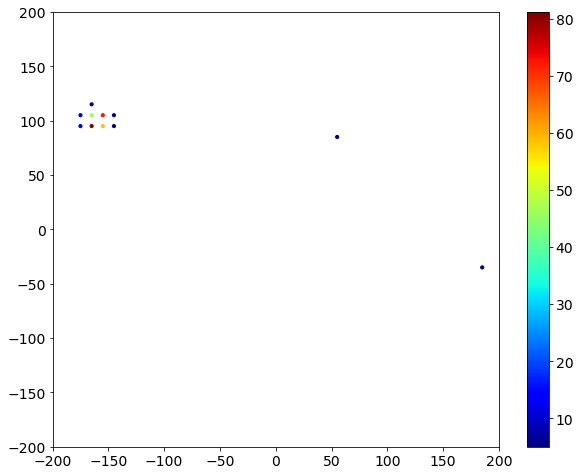

In [228]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal, xs, ys)

### Observations
- Many events with multiple S1. Perhaps increased grass due to high Krypton rate.